In [1]:
using PyPlot, JLD, AnomalyDetection, EvalCurves
import PyPlot: plot
using ScikitLearn: @sk_import, fit!, predict
using ScikitLearn.Utils: meshgrid 

In [2]:
dataset = load("toy_data_3.jld")["data"]

AnomalyDetection.Dataset(Float32[0.803442 0.804605 … 0.252366 -0.216809; 0.821998 0.834235 … 0.714171 1.09756], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

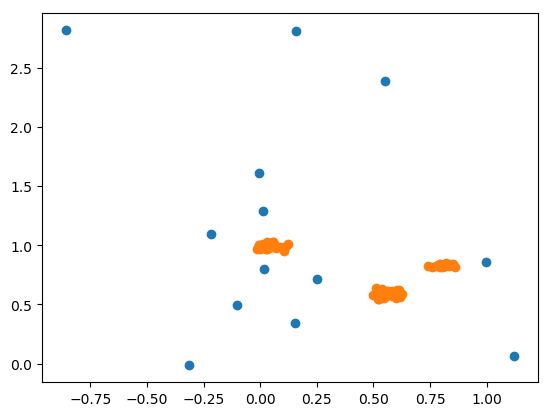

In [3]:
figure()
X = dataset.data
y = dataset.labels
scatter(X[1, y.==1], X[2, y.==1])
scatter(X[1, y.==0], X[2, y.==0])
show()

In [4]:
# import the isolation forest from SKlearn
@sk_import ensemble: IsolationForest

PyObject <class 'sklearn.ensemble.iforest.IsolationForest'>

In [5]:
n_estimators=100  # how many estimators to use
max_samples="auto" # how many samples to draw from X for each estimator
contamination = size(y[y.==1],1)/size(y,1) # to set the decision threshold
max_features=1.0 # how many features to use (if float, then it is a ratio)
bootstrap=false # bootstrapping - if false, sample without replacing
n_jobs=1 # how many cores to use
#random_state=None # seed or generator
verbose=0 # verbosity of the fitting
isoforest = IsolationForest(n_estimators, max_samples, contamination, max_features, bootstrap,
    n_jobs, verbose)

PyObject IsolationForest(bootstrap=False, contamination=0.1262135922330097,
        max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
        random_state=0, verbose=0)

In [6]:
fit!(isoforest, X[:,y.==0]')

PyObject IsolationForest(bootstrap=False, contamination=0.1262135922330097,
        max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
        random_state=0, verbose=0)

In [7]:
import ScikitLearn: decision_function

In [8]:
decision_function(isoforest, X')[:]

103-element Array{Float64,1}:
  0.0563444
  0.0647463
  0.0707768
 -0.0382797
 -0.0831636
  0.011229 
  0.0230698
  0.0714948
  0.0526769
  0.0679009
  0.0771799
 -0.0192895
 -0.0339993
  ⋮        
 -0.0479485
 -0.0909   
 -0.0986153
 -0.0980974
 -0.0872322
 -0.126248 
 -0.126248 
 -0.0873423
 -0.111835 
 -0.0722266
 -0.0978438
 -0.0909   

In [9]:
tsthat = AnomalyDetection.labels2bin(predict(isoforest, dataset.data'))

103-element Array{Int64,1}:
 1
 1
 1
 0
 0
 1
 1
 1
 1
 1
 1
 1
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [10]:
# anomaly score contour plot
# get limits of the figure
xl = (minimum(X[1,:])-0.05, maximum(X[1,:]) + 0.05)
yl = (minimum(X[2,:])-0.05, maximum(X[2,:]) + 0.05)

# compute the anomaly score on a grid
x = linspace(xl[1], xl[2], 30)
y = linspace(yl[1], yl[2], 30)
zz = zeros(size(y,1),size(x,1))
for i in 1:size(y, 1)
    for j in 1:size(x, 1)
        zz[i,j] = ScikitLearn.decision_function(isoforest, [x[j], y[i]]')[1]
    end
end

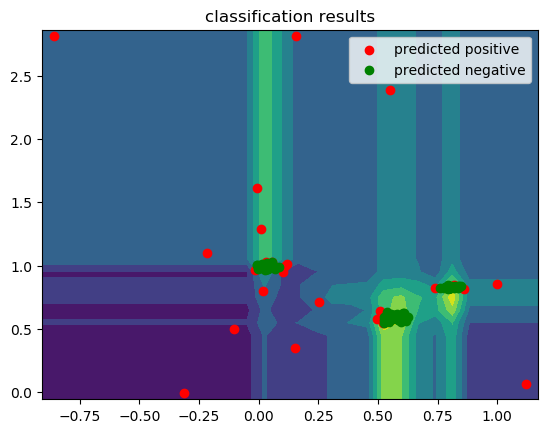

In [11]:
# plot it all
f = figure()
contourf(x, y, zz)
scatter(X[1, tsthat.==0], X[2, tsthat.==0], c = "r", 
    label = "predicted positive")
scatter(X[1, tsthat.==1], X[2, tsthat.==1], c = "g", 
    label = "predicted negative")
title("classification results")
xlim(xl)
ylim(yl)
legend()
show()
